In [2]:
from matplotlib import pyplot as plt

Goal: Linear regression on this graph from [spurious correlations](https://tylervigen.com/spurious/correlation),
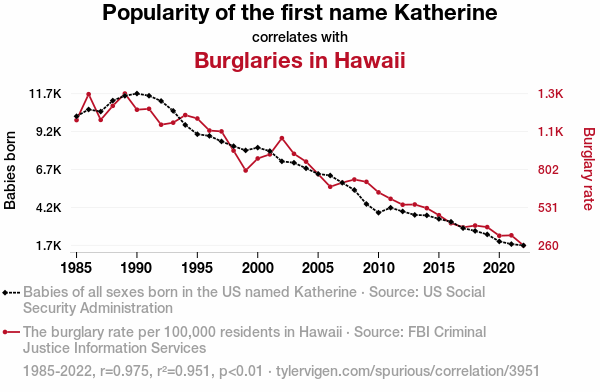

TODO: insert joke about katherine crime spree here

Handily, the data for this graph are easily accessible:

Text(0, 0.5, 'Burglaries in Hawaii')

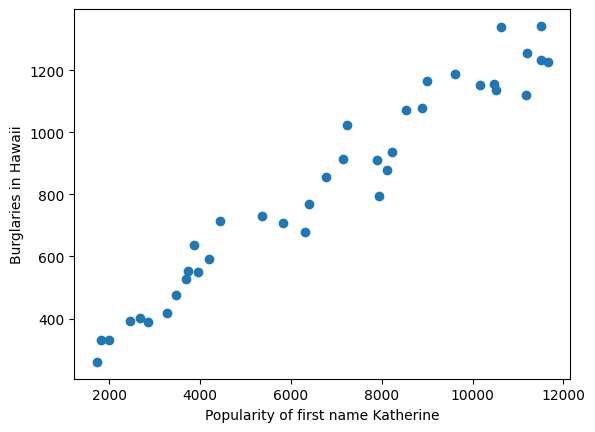

In [4]:
katherine_popularity = [10171,10616,10480,11196,11509,11657,11514,11170,10525,9605,9000,8890,8527,8217,7942,8122,7894,7224,7135,6771,6405,6300,5825,5354,4435,3868,4193,3951,3722,3693,3462,3274,2860,2676,2449,1989,1816,1727]
hawaii_burglaries = [1154.1,1338.8,1155.6,1255.8,1343.4,1228.2,1234.4,1121.2,1135.7,1189.9,1165.3,1079.5,1073.4,936.2,794.7,880.3,909.7,1025.4,913.6,857.8,769,678.6,708.2,730,713.7,638.6,592.5,550.5,552,526,475.7,418.8,389.6,401.9,390.9,329.1,332.2,260]

fig, ax = plt.subplots()
ax.scatter(katherine_popularity, hawaii_burglaries)
ax.set_xlabel('Popularity of first name Katherine')
ax.set_ylabel('Burglaries in Hawaii')

We can see pretty clearly that there is a linear trend here. If we can figure out how to draw a straight line on this graph, then we'll be able to accurately predict how much a rapid influx of Katherines will cause burglaries to spike in Hawaii, giving the Hawaian government time to prepare.

If you remember from high school, a straight line on a graph follows this formula:
$$y=mx + c$$
In this case, we have:
$$\text{Hawaii Burglaries} = m \times (\text{Katherine Popularity})  + c$$

If we can figure out how to find $m$ and $c$, we'll have our answer.

Imaging that we had an $m$ and $c$ that we thought were pretty good. How would we measure how good they actually are?
One way is **Mean Squared Error**.

If put one of our popularities into our equation to get a prediction of `y`, we can compare it to the actual value of `y` by subtracting one from the other. To avoid having to deal with negative errors (what would that even mean?) we can square the result. Finally, we can do this for every value of burglary rate and katherine popularity in our dataset and average the results.

In [17]:
def mean_square_error(
    actuals: list[float], 
    predictions: list[float]
) -> float:
    
    total = 0
    for actual, prediction in zip(actuals, predictions):
        difference = actual - prediction
        total = total + difference

    return total / len(square_errors)

slope = 1 # this is just a guess for now
intercept = 1 # so is this

predictions = []
for x in katherine_popularity:
    prediction = (x * slope) + intercept
    predictions.append(prediction)

error = mean_square_error(hawaii_burglaries, predictions)
print(f"Error: {error:.0f}")

Error: 43319658


Now, if we have a guess, we can figure out how good our guess is. The next goal is to figure out how to pick a slope and intercept that gets this error as small as possible.

To help, we can use a result from multivariate calculus (ooh scary):

If we have function of multiple inputs $f(a,b,c...)$ and a small enough constant $\mu$: 
$$f(a,b,c...) > f\left (a - \mu\frac{\partial f}{\partial a}, b - \mu\frac{\partial f}{\partial b}, c - \mu\frac{\partial f}{\partial c}, ...\right)$$

In our case, this means that if we have a guess for a good slope and intercept, we can reduce our mean square error by adjusting our parameters by subtracting the partial derivative of the error with respect to each parameter:
$$\text{slope} \rightarrow \text{slope} - \mu\frac{\partial (\text{mse})}{\partial (\text{slope})}$$
$$\text{intercept} \rightarrow \text{intercept} - \mu\frac{\partial (\text{mse})}{\partial (\text{intercept})}$$

All that remains is to figure out the values of $\frac{\partial (\text{mse})}{\partial (\text{slope})}$ and $\frac{\partial (\text{mse})}{\partial (\text{intercept})}$.